# LiberTEM-Holo : Simple Reconstruction Example
This code below provides a simple example to use LiberTEM-Holo for reconstruction.

### Getting Started
These first few cells below are preparatory: importing the necessary python libraries and function, loading and preparing the input data.
In this example the input data is formatted as .dm3.

In [1]:
# Import necessary Libaries and Function
%matplotlib nbagg 
import numpy as np
from ncempy.io.dm import fileDM  # package to load DM file
import matplotlib.pyplot as plt 
from skimage.restoration import unwrap_phase
from scipy.signal import fftconvolve
from skimage.filters import window
from skimage.draw import polygon

# LiberTem-Holo Package
from libertem_holo.base.reconstr import (get_aperture,
                                         reconstruct_frame,
                                         get_slice_fft,
                                         estimate_sideband_position,
                                         estimate_sideband_size)

from libertem_holo.base.filters import clipped, window_filter

In [2]:
# Loading data from DM4 file
with fileDM ('/cachedata/users/gunawan/04_alpha+0_obj.dm4') as f:
    data = f.getDataset(0)
with fileDM ('/cachedata/users/gunawan/05_alpha+0_ref.dm4') as f:
    data_ref = f.getDataset(0)
# The input data contain one stack of Images, in this example only one of the images is used
image_original = data['data'][0]
# Image reference for better reconstruction
image_reference = data_ref['data'][0] 

It is recomended to see the original input data before reconstruction to have a better understanding the effect of the reconstruction with the package

<IPython.core.display.Javascript object>


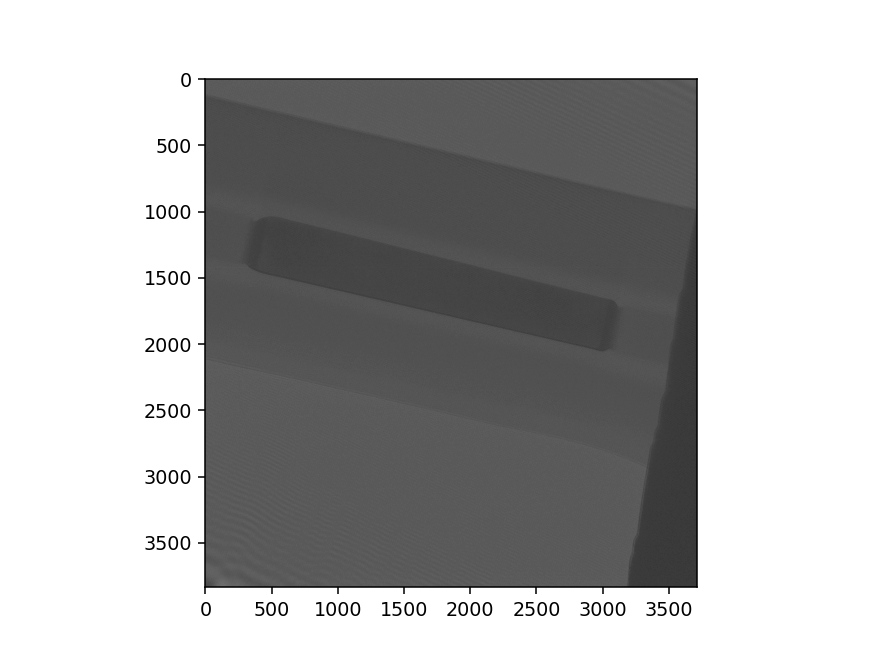

<IPython.core.display.Javascript object>


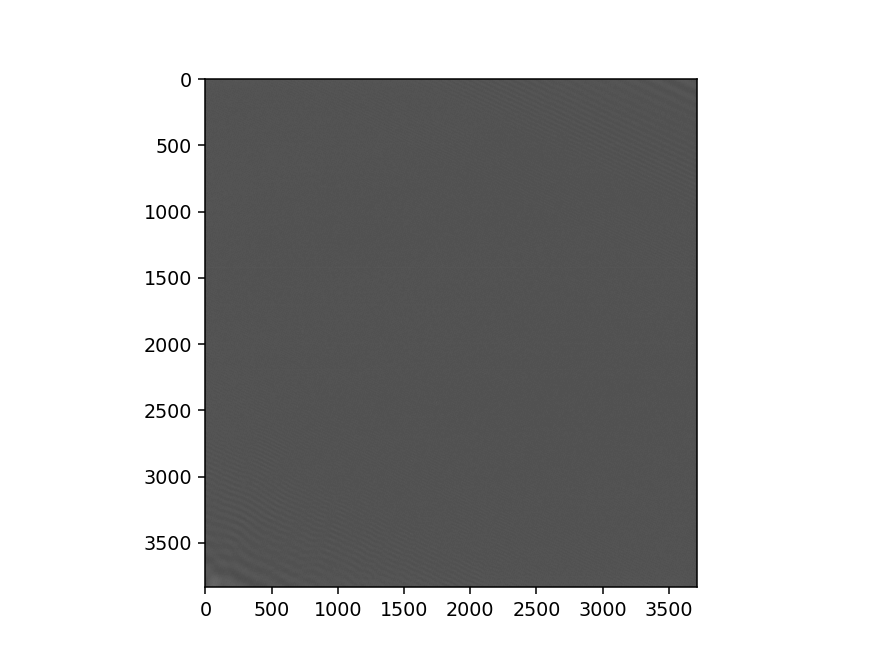

In [3]:
plt.figure()
plt.imshow(image_original, vmax=np.max(clipped(image_original)), cmap="gray")
plt.figure()
plt.imshow(image_reference, vmax=np.max(clipped(image_reference)), cmap="gray")

### Creating an Aperture
For the purpose of reconstruction, it is necessary to create an Aperture. The requirements to create an aperture are the position of the sideband and the size of the sideband.

#### Estimation of the sideband's position and size
In the liberTEM-Holo package, there are two functions to estimate the position and the size of the sideband. Here the reference image is used to defined the sideband's position and size.

In [4]:
# Estimate the position of the sidebands
sb_position = estimate_sideband_position(image_reference, holo_sampling=(1,1)) 
# Estimate the size of the sidebands
sb_size = estimate_sideband_size(sb_position,
                                 image_reference.shape,
                                 sb_size_ratio=0.5) 

#### Creating aperture and slice_fft
After the sideband's size is estimated, the aperture is created with get_aperture function. The slice_fft is needed later for the reconstruct_frame function

In [5]:
# Example to use the two option to create an Aperture

# Before using the get_aperture or get_aperture_gauss function, the size of the output need to be defined 
out_shape = (1024, 1024)

#Create an Aperture and an array for slice_fft
aperture = get_aperture(out_shape=out_shape, sb_size=sb_size)
slice_fft = get_slice_fft(out_shape=out_shape, sig_shape=image_reference.shape)

#### Filtering the aperture
The aperture is filtered, so that the sharp edges are removed
With the window_filter function, there are a lot of posibilitiy to filter the aperture. To see the example of different filter applied to the aperture, please open the notebook example for Aperture.

<IPython.core.display.Javascript object>


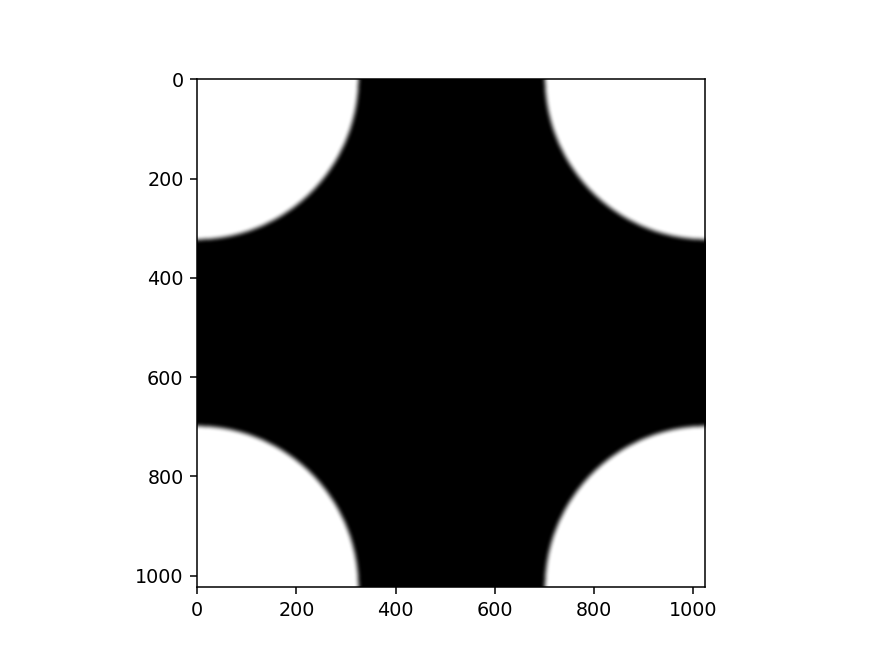

In [6]:
aperture_filtered = window_filter(aperture, 'hann', 25)  # Filtering

# Display the final aperture
plt.figure()
plt.imshow(aperture_filtered, cmap="gray")

### Reconstruction
The reconstruction is done by using the reconstruct_frame function. Both of the original image and reference image are reconstructed. After the reconstruction, the original image is divided by the reference image.

In [7]:
# Reconstruction of original image
wav_original = reconstruct_frame(image_original,
                                 sb_pos=sb_position,
                                 slice_fft=slice_fft,
                                 aperture=aperture_filtered)

# Reconstruction of reference image
wav_reference = reconstruct_frame(image_reference,
                                 sb_pos=sb_position,
                                 slice_fft=slice_fft,
                                 aperture=aperture_filtered)
# Correction with the reference image
wav_final = wav_original/wav_reference

<IPython.core.display.Javascript object>


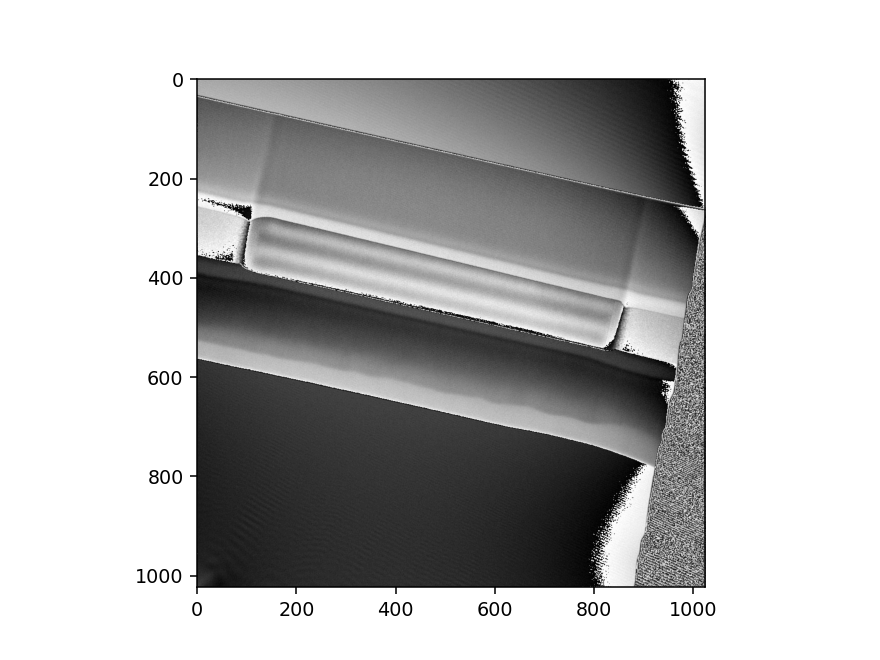

In [8]:
# Wrapped phase
plt.figure()
plt.imshow(np.angle(wav_final), cmap="gray")

### Unwrapping
The unwrapping is done by using skimage.restoration.unwrap_phase. For a better display, a mask is created to mask out the noise in the bottom left area. The minimum value and maximal value for vmin and vmax is calculated with numpy min and numpy max of the image without the noisy area.

<IPython.core.display.Javascript object>


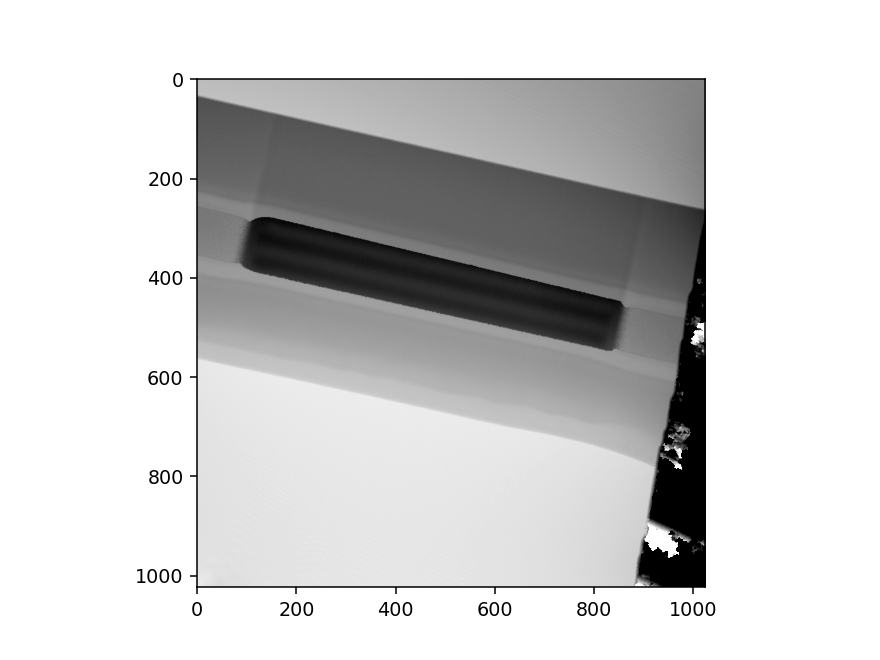

In [9]:
#unwrapping
unwrap_phase_image = unwrap_phase(np.angle(wav_final))

# Creating mask with skimage draw polygon

r = np.array([270, 1023 , 1023])
c = np.array([1023, 1023, 875])
rr, cc = polygon(r, c)
mask_roi = np.ones((1024, 1024)) 
mask_roi[rr, cc] = 0

# Calculating vmin, vmax
vmin = np.min(unwrap_phase_image*mask_roi)
vmax = np.max(unwrap_phase_image*mask_roi)

plt.figure()
plt.imshow(unwrap_phase_image, vmin=vmin, vmax=vmax, cmap="gray")